<a href="https://colab.research.google.com/github/MaryamNourii/Form-OCR/blob/Model/Form_OCR_ResNet18_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from google.colab.patches import cv2_imshow
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from sklearn.preprocessing import OneHotEncoder
import os
import tensorflow as tf
from tensorflow import keras
from keras import layers, models, Model
from keras.layers import  *
from keras.optimizers import Adam,SGD
import matplotlib.pyplot as plt
import fnmatch
from sklearn.decomposition import PCA

In [ ]:
!unzip -qx new_OCR_Data.zip -d OCR_Data

In [ ]:
!unzip -qx new_words.zip -d words

In [ ]:
w = 224 
h = 56

In [ ]:
test_path = 'words'
test_images = []
for item in os.listdir(test_path):
    img = cv2.imread(os.path.join(test_path,item), cv2.IMREAD_GRAYSCALE)
    if img is not None:
      img = cv2.resize(img, (w,h))
      test_images.append(img)


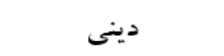

In [ ]:
path = 'OCR_Data'
all_images = []
all_labels = []

for item in os.listdir(path):
  count = len(fnmatch.filter(os.listdir(os.path.join(path,item)), '*.*'))
  i = 0
  for img_path in os.listdir(os.path.join(path,item)):
    img = cv2.imread(os.path.join(path,item,img_path), cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (w,h))

    all_labels.append(str(item))
    all_images.append(img)

cv2_imshow(all_images[50])

In [ ]:
classes = list(set(all_labels))  
classe_num=len(classes)

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(all_images, all_labels, test_size= 0.2)
train_x, val_x, train_y, val_y = train_test_split(train_x, train_y, test_size= 0.01)

In [ ]:
lbl_enc = LabelEncoder()
classe_enc = lbl_enc.fit_transform(classes)
trny = lbl_enc.transform(train_y)
tsty = lbl_enc.transform(test_y)
valy = lbl_enc.transform(val_y)

ohe = OneHotEncoder()
lbl_onehot = ohe.fit_transform(np.asarray(classe_enc).reshape(-1,1)).toarray()
trainy = ohe.transform(np.asarray(trny).reshape(-1,1)).toarray()
testy = ohe.transform(np.asarray(tsty).reshape(-1,1)).toarray()
valy = ohe.transform(np.asarray(valy).reshape(-1,1)).toarray()

In [ ]:
trainx = np.asarray(train_x).reshape(-1 ,w ,h, 1)
valx = np.asarray(val_x).reshape(-1, w, h, 1)
testx = np.asarray(test_x).reshape(-1 ,w ,h ,1)

trainx = trainx.astype('float32')
vlax = valx.astype('float32')
testx = testx.astype('float32')
trainx /= 255.0
vlax /= 255.0
testx /= 255.0
trainx.shape, testx.shape, trainy.shape, testy.shape , valy.shape, valx.shape

((4253, 224, 56, 1),
 (1074, 224, 56, 1),
 (4253, 89),
 (1074, 89),
 (43, 89),
 (43, 224, 56, 1))

In [ ]:
def Identity_Block(X,f,Fltrs):
    X_ShortCut = X
    f1,f2 = Fltrs

    X = Conv2D(filters=f1, kernel_size=(f,f), strides=(1,1),padding="same")(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation("relu")(X)

    X = Conv2D(filters=f2, kernel_size=(f,f), strides=(1,1),padding="same")(X)
    X = BatchNormalization(axis=3)(X)

    X = Add()([X, X_ShortCut])
    X = Activation("relu")(X)

    return X

def Convolutional_Block(X,f,Filters,s):
    X_ShortCut = X
    f1,f2 = Filters

    X = Conv2D(filters=f1, kernel_size=(f,f), strides=(s,s),padding="same")(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation("relu")(X)

    X = Conv2D(filters=f2, kernel_size=(f,f), strides=(1,1),padding="same")(X)
    X = BatchNormalization(axis=3)(X)

    X_ShortCut = Conv2D(filters=f2, kernel_size=(1,1), strides=(s,s),padding="same")(X_ShortCut)
    X_ShortCut = BatchNormalization(axis=3)(X_ShortCut)

    X = Add()([X, X_ShortCut])
    X = Activation("relu")(X)

    return X    

def Resnet18(W,H,classes=classe_num):
    x_input=Input(shape=(W,H,1),name="Input_Layer")

    #Stage1
    X = Conv2D(64,(7,7),strides=(2,2),padding="same")(x_input)
    X = MaxPooling2D((3,3),strides=(2,2),padding="same")(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation("relu")(X)
    L1=X

    #Stage2
    X = Identity_Block(X, 3, [64,64])
    X = Identity_Block(X, 3, [64,64])
    L2=X

    #Stage3
    X = Convolutional_Block(X, f=3, Filters = [64,128], s=2)
    X = Identity_Block(X, 3, [128,128])
    L3=X

    
    #Stage4
    X = Convolutional_Block(X, f=3, Filters = [128,256], s=2)
    X = Identity_Block(X, 3, [256,256])
    L4=X

    # Stage5
    X = Convolutional_Block(X, f=3, Filters = [256,512], s=2)
    X = Identity_Block(X, 3, [512,512])
    L5=X

    # Stage6
    X=GlobalAveragePooling2D()(X)
    # X=Dense(256,activation='relu')(X)
    # X=Dense(128,activation='relu')(X)
    x_Output=Dense(classe_num,activation='softmax')(X)


    return [x_input, L1, L2, L3, L4, L5, x_Output]

ResNet18 = Resnet18(w,h,classes = classe_num)    
ResNet18_model = Model(inputs = ResNet18[0], outputs = ResNet18[6])
ResNet18_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Input_Layer (InputLayer)       [(None, 224, 56, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 conv2d (Conv2D)                (None, 112, 28, 64)  3200        ['Input_Layer[0][0]']            
                                                                                                  
 max_pooling2d (MaxPooling2D)   (None, 56, 14, 64)   0           ['conv2d[0][0]']                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 56, 14, 64)  256         ['max_pooling2d[0][0]']      

In [ ]:
optimizer = SGD(learning_rate= 1e-03)

loss = tf.keras.losses.CategoricalCrossentropy()
metric = tf.keras.metrics.CategoricalAccuracy('accuracy')

ResNet18_model.compile(
    optimizer = optimizer,
    loss = loss,
    metrics = [metric])


log_dir = 'model_log'
model_save_path='ResNet18_model.h5'
callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath=model_save_path,
                                                save_weights_only=True,
                                                monitor='val_loss',mode='min'
                                                ,save_best_only=True),
                                                tf.keras.callbacks.TensorBoard(log_dir=log_dir)]

history = ResNet18_model.fit(x=trainx, y=trainy, 
                    epochs=30, 
                    validation_data=(valx,valy),
                    callbacks=callbacks, shuffle=True)

Epoch 1/30
133/133 [==============================] - 18s 54ms/step - loss: 4.6206 - accuracy: 0.0285 - val_loss: 4.5957 - val_accuracy: 0.0056
Epoch 2/30
133/133 [==============================] - 5s 36ms/step - loss: 4.1052 - accuracy: 0.0896 - val_loss: 4.6999 - val_accuracy: 0.0112
Epoch 3/30
133/133 [==============================] - 5s 36ms/step - loss: 3.7642 - accuracy: 0.2250 - val_loss: 4.6186 - val_accuracy: 0.0130
Epoch 4/30
133/133 [==============================] - 5s 36ms/step - loss: 3.4607 - accuracy: 0.4070 - val_loss: 4.2163 - val_accuracy: 0.0568
Epoch 5/30
133/133 [==============================] - 5s 38ms/step - loss: 3.1791 - accuracy: 0.5493 - val_loss: 3.6484 - val_accuracy: 0.2579
Epoch 6/30
133/133 [==============================] - 5s 36ms/step - loss: 2.8902 - accuracy: 0.6849 - val_loss: 3.2783 - val_accuracy: 0.4115
Epoch 7/30
133/133 [==============================] - 5s 36ms/step - loss: 2.6228 - accuracy: 0.7578 - val_loss: 2.8850 - val_accuracy: 0.555

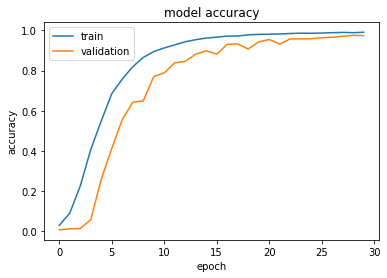

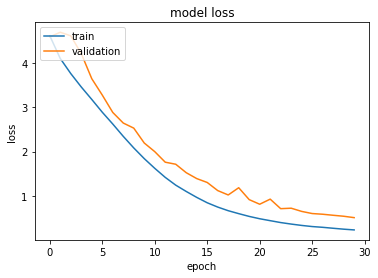

In [ ]:
#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()


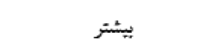

1/1 [==============================] - 1s 1s/step
['بیشتر']


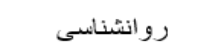

1/1 [==============================] - 0s 72ms/step
['روانشناسی']


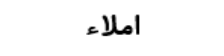

1/1 [==============================] - 0s 32ms/step
['املاء']


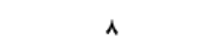

1/1 [==============================] - 0s 32ms/step
['8']


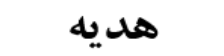

1/1 [==============================] - 0s 77ms/step
['جامعه']


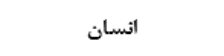

1/1 [==============================] - 0s 39ms/step
['انسان']


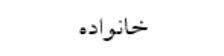

1/1 [==============================] - 0s 112ms/step
['خانواده']


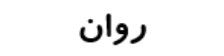

1/1 [==============================] - 0s 85ms/step
['روان']


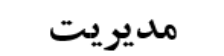

1/1 [==============================] - 0s 42ms/step
['مدیریت']


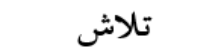

1/1 [==============================] - 0s 71ms/step
['تلاش']


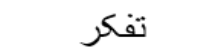

1/1 [==============================] - 0s 31ms/step
['تفکر']


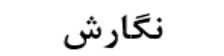

1/1 [==============================] - 0s 45ms/step
['نگارش']


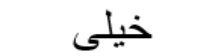

1/1 [==============================] - 0s 67ms/step
['خیلی']


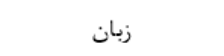

1/1 [==============================] - 0s 51ms/step
['زبان']


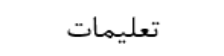

1/1 [==============================] - 0s 35ms/step
['تعلیمات']


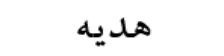

1/1 [==============================] - 0s 36ms/step
['هدیه']


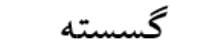

1/1 [==============================] - 0s 59ms/step
['گسسته']


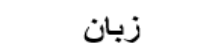

1/1 [==============================] - 0s 73ms/step
['زبان']


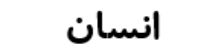

1/1 [==============================] - 0s 35ms/step
['انسان']


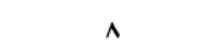

1/1 [==============================] - 0s 63ms/step
['8']


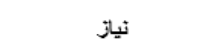

1/1 [==============================] - 0s 20ms/step
['نیاز']


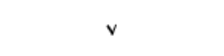

1/1 [==============================] - 0s 20ms/step
['7']


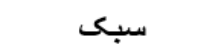

1/1 [==============================] - 0s 22ms/step
['سبک']


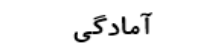

1/1 [==============================] - 0s 20ms/step
['آمادگی']


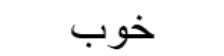

1/1 [==============================] - 0s 20ms/step
['خوب']


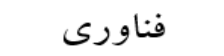

1/1 [==============================] - 0s 19ms/step
['فناوری']


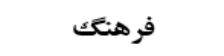

1/1 [==============================] - 0s 21ms/step
['فرهنگ']


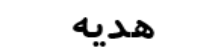

1/1 [==============================] - 0s 20ms/step
['هدیه']


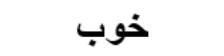

1/1 [==============================] - 0s 20ms/step
['خوب']


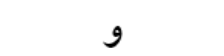

1/1 [==============================] - 0s 22ms/step
['و']


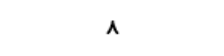

1/1 [==============================] - 0s 20ms/step
['8']


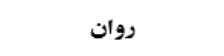

1/1 [==============================] - 0s 20ms/step
['روان']


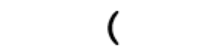

1/1 [==============================] - 0s 19ms/step
['(']


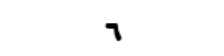

1/1 [==============================] - 0s 20ms/step
['9']


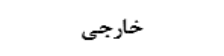

1/1 [==============================] - 0s 21ms/step
['خارجی']


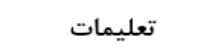

1/1 [==============================] - 0s 22ms/step
['تعلیمات']


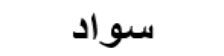

1/1 [==============================] - 0s 19ms/step
['سواد']


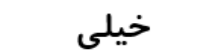

1/1 [==============================] - 0s 19ms/step
['خیلی']


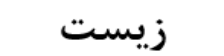

1/1 [==============================] - 0s 21ms/step
['روانشناسی']


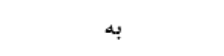

1/1 [==============================] - 0s 20ms/step
['به']


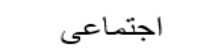

1/1 [==============================] - 0s 21ms/step
['اجتماعی']


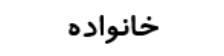

1/1 [==============================] - 0s 24ms/step
['خانواده']


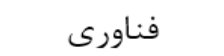

1/1 [==============================] - 0s 20ms/step
['فناوری']


In [ ]:
for img in test_x:
  cv2_imshow(img)
  img = np.asarray(img).reshape(1, w,h, 1)
  img = img.astype('float32')
  img /= 255.0  
  pred_y = ResNet18_model.predict(img)
  prediction = np.argmax(pred_y)
  y=lbl_enc.inverse_transform([prediction])
  print(y)

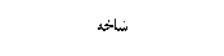

1/1 [==============================] - 0s 21ms/step
['3']


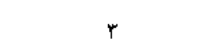

1/1 [==============================] - 0s 23ms/step
['4']


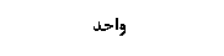

1/1 [==============================] - 0s 21ms/step
['دفاعی']


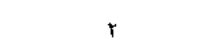

1/1 [==============================] - 0s 21ms/step
['2']


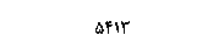

1/1 [==============================] - 0s 21ms/step
['انشاء']


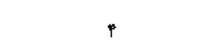

1/1 [==============================] - 0s 20ms/step
['0']


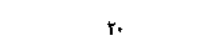

1/1 [==============================] - 0s 21ms/step
['4']


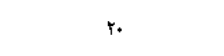

1/1 [==============================] - 0s 19ms/step
['به']


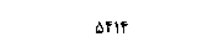

1/1 [==============================] - 0s 20ms/step
['زبان']


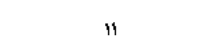

1/1 [==============================] - 0s 23ms/step
['6']


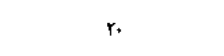

1/1 [==============================] - 0s 20ms/step
['4']


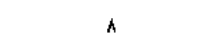

1/1 [==============================] - 0s 20ms/step
['8']


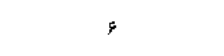

1/1 [==============================] - 0s 21ms/step
['6']


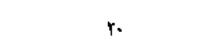

1/1 [==============================] - 0s 21ms/step
['4']


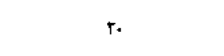

1/1 [==============================] - 0s 20ms/step
['3']


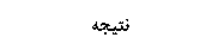

1/1 [==============================] - 0s 24ms/step
['املاء']


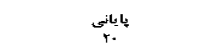

1/1 [==============================] - 0s 25ms/step
['زبان']


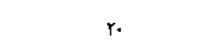

1/1 [==============================] - 0s 22ms/step
['3']


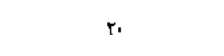

1/1 [==============================] - 0s 26ms/step
['6']


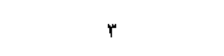

1/1 [==============================] - 0s 20ms/step
['4']


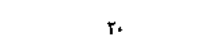

1/1 [==============================] - 0s 23ms/step
['4']


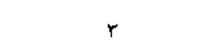

1/1 [==============================] - 0s 20ms/step
['4']


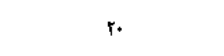

1/1 [==============================] - 0s 20ms/step
['4']


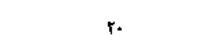

1/1 [==============================] - 0s 21ms/step
['4']


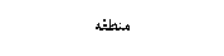

1/1 [==============================] - 0s 22ms/step
['استان']


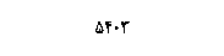

1/1 [==============================] - 0s 22ms/step
['زمین']


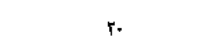

1/1 [==============================] - 0s 21ms/step
['4']


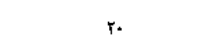

1/1 [==============================] - 0s 20ms/step
['3']


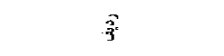

1/1 [==============================] - 0s 20ms/step
['4']


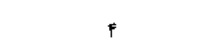

1/1 [==============================] - 0s 23ms/step
['4']


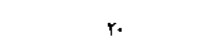

1/1 [==============================] - 0s 24ms/step
['4']


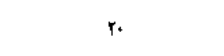

1/1 [==============================] - 0s 22ms/step
['به']


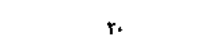

1/1 [==============================] - 0s 22ms/step
['4']


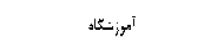

1/1 [==============================] - 0s 22ms/step
['تربیت']


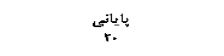

1/1 [==============================] - 0s 23ms/step
['زبان']


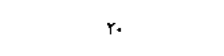

1/1 [==============================] - 0s 21ms/step
['3']


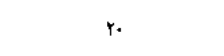

1/1 [==============================] - 0s 20ms/step
['3']


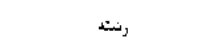

1/1 [==============================] - 0s 21ms/step
['به']


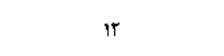

1/1 [==============================] - 0s 22ms/step
['3']


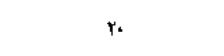

1/1 [==============================] - 0s 21ms/step
['به']


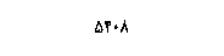

1/1 [==============================] - 0s 23ms/step
['زمین']


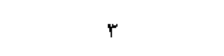

1/1 [==============================] - 0s 22ms/step
['4']


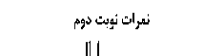

1/1 [==============================] - 0s 23ms/step
['ریاضیات']


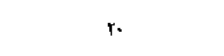

1/1 [==============================] - 0s 23ms/step
['4']


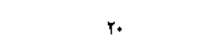

1/1 [==============================] - 0s 21ms/step
['4']


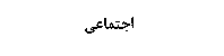

1/1 [==============================] - 0s 20ms/step
['انشاء']


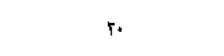

1/1 [==============================] - 0s 20ms/step
['4']


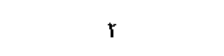

1/1 [==============================] - 0s 20ms/step
['2']


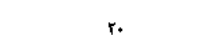

1/1 [==============================] - 0s 21ms/step
['به']


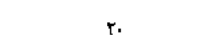

1/1 [==============================] - 0s 22ms/step
['4']


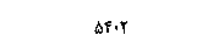

1/1 [==============================] - 0s 23ms/step
['زمین']


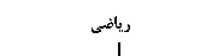

1/1 [==============================] - 0s 21ms/step
['دفاعی']


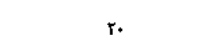

1/1 [==============================] - 0s 25ms/step
['4']


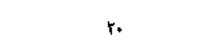

1/1 [==============================] - 0s 22ms/step
['6']


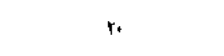

1/1 [==============================] - 0s 22ms/step
['به']


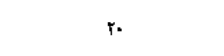

1/1 [==============================] - 0s 24ms/step
['4']


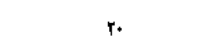

1/1 [==============================] - 0s 23ms/step
['4']


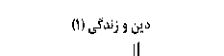

1/1 [==============================] - 0s 22ms/step
['ریاضیات']


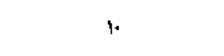

1/1 [==============================] - 0s 22ms/step
['3']


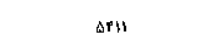

1/1 [==============================] - 0s 22ms/step
['زبان']


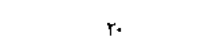

1/1 [==============================] - 0s 23ms/step
['3']


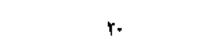

1/1 [==============================] - 0s 21ms/step
['4']


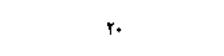

1/1 [==============================] - 0s 22ms/step
['3']


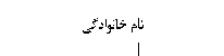

1/1 [==============================] - 0s 23ms/step
['فناوری']


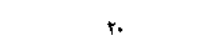

1/1 [==============================] - 0s 22ms/step
['به']


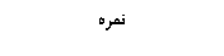

1/1 [==============================] - 0s 22ms/step
['3']


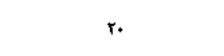

1/1 [==============================] - 0s 22ms/step
['به']


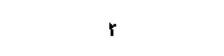

1/1 [==============================] - 0s 22ms/step
['4']


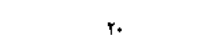

1/1 [==============================] - 0s 29ms/step
['4']


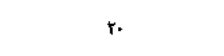

1/1 [==============================] - 0s 22ms/step
['3']


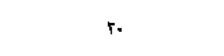

1/1 [==============================] - 0s 21ms/step
['به']


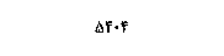

1/1 [==============================] - 0s 20ms/step
['زمین']


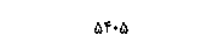

1/1 [==============================] - 0s 21ms/step
['هدیه']


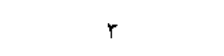

1/1 [==============================] - 0s 24ms/step
['4']


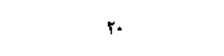

1/1 [==============================] - 0s 25ms/step
['4']


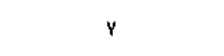

1/1 [==============================] - 0s 21ms/step
['2']


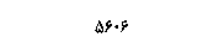

1/1 [==============================] - 0s 21ms/step
['زبان']


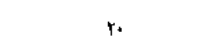

1/1 [==============================] - 0s 22ms/step
['به']


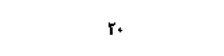

1/1 [==============================] - 0s 24ms/step
['4']


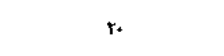

1/1 [==============================] - 0s 22ms/step
['6']


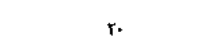

1/1 [==============================] - 0s 21ms/step
['4']


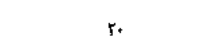

1/1 [==============================] - 0s 21ms/step
['به']


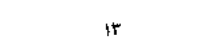

1/1 [==============================] - 0s 28ms/step
['3']


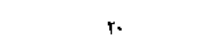

1/1 [==============================] - 0s 21ms/step
['به']


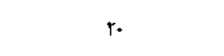

1/1 [==============================] - 0s 23ms/step
['3']


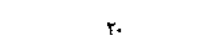

1/1 [==============================] - 0s 20ms/step
['6']


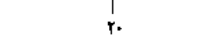

1/1 [==============================] - 0s 27ms/step
['4']


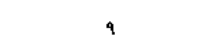

1/1 [==============================] - 0s 22ms/step
['2']


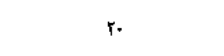

1/1 [==============================] - 0s 21ms/step
['4']


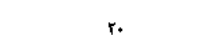

1/1 [==============================] - 0s 21ms/step
['به']


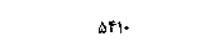

1/1 [==============================] - 0s 20ms/step
['زبان']


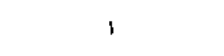

1/1 [==============================] - 0s 26ms/step
['4']


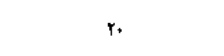

1/1 [==============================] - 0s 22ms/step
['به']


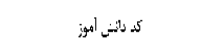

1/1 [==============================] - 0s 21ms/step
['فناوری']


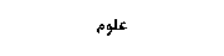

1/1 [==============================] - 0s 21ms/step
['هنر']


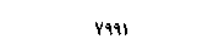

1/1 [==============================] - 0s 29ms/step
['هدیه']


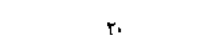

1/1 [==============================] - 0s 26ms/step
['6']


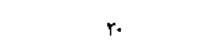

1/1 [==============================] - 0s 22ms/step
['3']


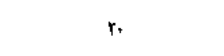

1/1 [==============================] - 0s 22ms/step
['به']


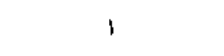

1/1 [==============================] - 0s 20ms/step
['4']


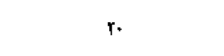

1/1 [==============================] - 0s 21ms/step
['4']


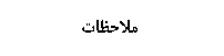

1/1 [==============================] - 0s 20ms/step
['آزمایشگاه']


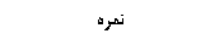

1/1 [==============================] - 0s 21ms/step
['3']


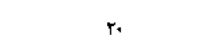

1/1 [==============================] - 0s 21ms/step
['3']


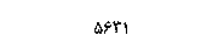

1/1 [==============================] - 0s 21ms/step
['انشاء']


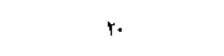

1/1 [==============================] - 0s 21ms/step
['4']


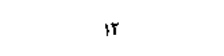

1/1 [==============================] - 0s 20ms/step
['6']


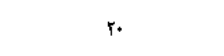

1/1 [==============================] - 0s 22ms/step
['4']


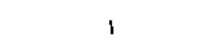

1/1 [==============================] - 0s 21ms/step
['(']


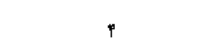

1/1 [==============================] - 0s 22ms/step
['0']


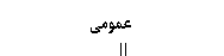

1/1 [==============================] - 0s 31ms/step
['بدنی']


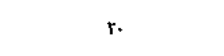

1/1 [==============================] - 0s 40ms/step
['4']


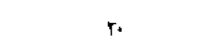

1/1 [==============================] - 0s 30ms/step
['4']


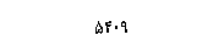

1/1 [==============================] - 0s 38ms/step
['زمین']


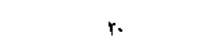

1/1 [==============================] - 0s 30ms/step
['به']


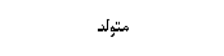

1/1 [==============================] - 0s 38ms/step
['سبک']


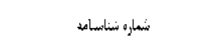

1/1 [==============================] - 0s 33ms/step
['فلسفه']


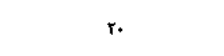

1/1 [==============================] - 0s 30ms/step
['به']


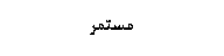

1/1 [==============================] - 0s 29ms/step
['املاء']


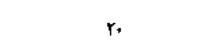

1/1 [==============================] - 0s 40ms/step
['3']


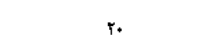

1/1 [==============================] - 0s 33ms/step
['به']


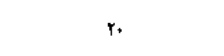

1/1 [==============================] - 0s 32ms/step
['به']


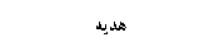

1/1 [==============================] - 0s 31ms/step
['3']


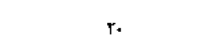

1/1 [==============================] - 0s 33ms/step
['3']


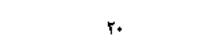

1/1 [==============================] - 0s 30ms/step
['4']


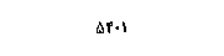

1/1 [==============================] - 0s 31ms/step
['زمین']


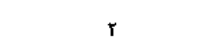

1/1 [==============================] - 0s 34ms/step
['2']


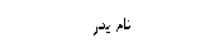

1/1 [==============================] - 0s 32ms/step
['جامعه']


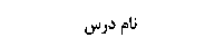

1/1 [==============================] - 0s 38ms/step
['ریاضیات']


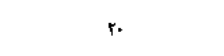

1/1 [==============================] - 0s 30ms/step
['به']


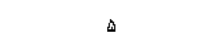

1/1 [==============================] - 0s 30ms/step
['6']


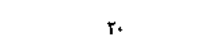

1/1 [==============================] - 0s 29ms/step
['4']


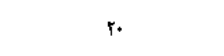

1/1 [==============================] - 0s 34ms/step
['4']


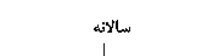

1/1 [==============================] - 0s 21ms/step
['روان']


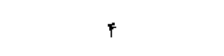

1/1 [==============================] - 0s 21ms/step
['4']


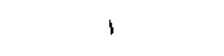

1/1 [==============================] - 0s 20ms/step
['4']


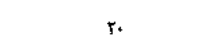

1/1 [==============================] - 0s 21ms/step
['4']


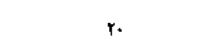

1/1 [==============================] - 0s 21ms/step
['4']


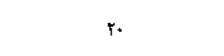

1/1 [==============================] - 0s 20ms/step
['4']


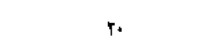

1/1 [==============================] - 0s 24ms/step
['4']


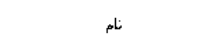

1/1 [==============================] - 0s 21ms/step
['0']


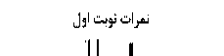

1/1 [==============================] - 0s 22ms/step
['خارجی']


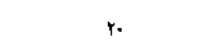

1/1 [==============================] - 0s 22ms/step
['4']


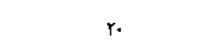

1/1 [==============================] - 0s 22ms/step
['3']


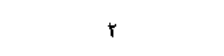

1/1 [==============================] - 0s 22ms/step
['4']


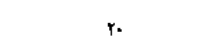

1/1 [==============================] - 0s 23ms/step
['به']


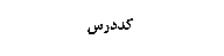

1/1 [==============================] - 0s 21ms/step
['قرائت']


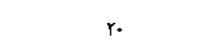

1/1 [==============================] - 0s 21ms/step
['3']


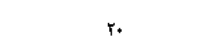

1/1 [==============================] - 0s 20ms/step
['به']


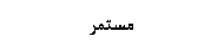

1/1 [==============================] - 0s 23ms/step
['سبک']


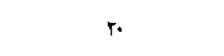

1/1 [==============================] - 0s 23ms/step
['به']


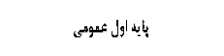

1/1 [==============================] - 0s 21ms/step
['مطالعات']


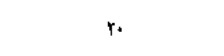

1/1 [==============================] - 0s 21ms/step
['3']


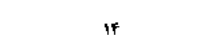

1/1 [==============================] - 0s 28ms/step
['3']


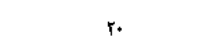

1/1 [==============================] - 0s 22ms/step
['4']


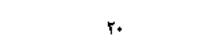

1/1 [==============================] - 0s 21ms/step
['4']


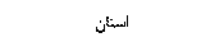

1/1 [==============================] - 0s 20ms/step
['آمار']


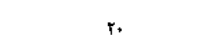

1/1 [==============================] - 0s 20ms/step
['4']


In [ ]:
for img in test_images:
  cv2_imshow(img)
  img = np.asarray(img).reshape(1, w,h, 1)
  img = img.astype('float32')
  img /= 255.0  
  pred_y = ResNet18_model.predict(img)
  prediction = np.argmax(pred_y)
  y=lbl_enc.inverse_transform([prediction])
  print(y)